In [ ]:
intermediate_dim = 256
output_dim = 128
seed = 42

import numpy as np
import matplotlib.pyplot as plt
import torch
from SimCLR import Net

model = Net(output_dim=output_dim, intermediate_dim=intermediate_dim)
torch.manual_seed(seed)

c:\Users\yoann\anaconda3\envs\IFT6135\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yoann\anaconda3\envs\IFT6135\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from SimCLR import SimCLRDataset
from torchvision import datasets

batch_size = 3072
# load CIFAR-10 dataset
cifar10_dataset = datasets.CIFAR10(root="./data", train=True, download=True)
dataset = SimCLRDataset(cifar10_dataset)
dataset_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Files already downloaded and verified


In [ ]:
from SimCLR import SimCLR_Loss

temperature = 0.1
# Instantiate and test the loss function
simclr_loss_fn = SimCLR_Loss(temperature=temperature)
projections = torch.rand(10, 128)
loss = simclr_loss_fn(projections)
print(f"SimCLR loss: {loss.item()}")

SimCLR loss: 2.295924186706543


# TRAINING

In [ ]:
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from tqdm import tqdm
epochs = 70
lr = 1e-4
weight_decay = 1e-4

class Trainer:
    def __init__(self, model, dataset_loader, loss_fn, lr=1e-3, weight_decay=1e-4):
        self.loss_list = []
        self.model = model
        self.dataset_loader = dataset_loader
        self.loss_fn = loss_fn
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=lr, weight_decay=weight_decay
        )
        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=10, gamma=0.1
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fp16_precision = True

    def train(self, epochs=70):
        self.model.to(self.device)
        best_loss = float("inf")
        best_model = None
        scaler = GradScaler( enabled=self.fp16_precision)
        for epoch in range(epochs):
            running_loss = 0.0
            for img1, img2 in tqdm(self.dataset_loader):
                img1, img2 = img1.to(self.device), img2.to(self.device)
                img = torch.cat([img1, img2], dim=0)
                with autocast(enabled=self.fp16_precision):
                    projections = self.model(img)
                    loss = self.loss_fn(projections)
                self.optimizer.zero_grad()
                # loss.backward()
                # self.optimizer.step()
                scaler.scale(loss).backward()
                scaler.step(self.optimizer)
                scaler.update()
                if epoch >= 10:
                    self.scheduler.step()
                running_loss += loss.item()

            epoch_loss = running_loss / len(self.dataset_loader)
            self.loss_list.append(epoch_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
            if epoch % 10 == 0:
                torch.save(self.model.state_dict(), f"model_epoch_{epoch}.pth")
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model = self.model
        torch.save(best_model.state_dict(), "best_model.pth")
        return best_model

trainer = Trainer(
    model, dataset_loader, simclr_loss_fn, lr=lr, weight_decay=weight_decay
)
best_model = trainer.train(epochs=epochs)

C:\Users\yoann\AppData\Local\Temp\ipykernel_32932\4111565839.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler( enabled=self.fp16_precision)
  0%|          | 0/17 [00:00<?, ?it/s]C:\Users\yoann\AppData\Local\Temp\ipykernel_32932\4111565839.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.fp16_precision):
100%|██████████| 17/17 [00:45<00:00,  2.66s/it]


Epoch [1/70], Loss: 8.11390141879811


100%|██████████| 17/17 [00:44<00:00,  2.60s/it]


Epoch [2/70], Loss: 7.334105435539694


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Epoch [3/70], Loss: 6.772328713360955


100%|██████████| 17/17 [00:44<00:00,  2.59s/it]


Epoch [4/70], Loss: 6.363042494829963


100%|██████████| 17/17 [00:45<00:00,  2.65s/it]


Epoch [5/70], Loss: 6.084622018477496


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Epoch [6/70], Loss: 5.816486863528981


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Epoch [7/70], Loss: 5.579159484190099


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Epoch [8/70], Loss: 5.363011079676011


100%|██████████| 17/17 [00:44<00:00,  2.64s/it]


Epoch [9/70], Loss: 5.184673169079949


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [10/70], Loss: 5.03786911683924


100%|██████████| 17/17 [00:43<00:00,  2.59s/it]


Epoch [11/70], Loss: 4.868747851427863


100%|██████████| 17/17 [00:44<00:00,  2.60s/it]


Epoch [12/70], Loss: 4.819993495941162


100%|██████████| 17/17 [00:43<00:00,  2.57s/it]


Epoch [13/70], Loss: 4.817594640395221


100%|██████████| 17/17 [00:44<00:00,  2.59s/it]


Epoch [14/70], Loss: 4.820855982163373


100%|██████████| 17/17 [00:44<00:00,  2.63s/it]


Epoch [15/70], Loss: 4.822329885819379


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [16/70], Loss: 4.844111919403076


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [17/70], Loss: 4.818414197248571


100%|██████████| 17/17 [00:43<00:00,  2.55s/it]


Epoch [18/70], Loss: 4.817500030293184


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Epoch [19/70], Loss: 4.821774216259227


100%|██████████| 17/17 [00:44<00:00,  2.61s/it]


Epoch [20/70], Loss: 4.825462916318108


100%|██████████| 17/17 [00:44<00:00,  2.59s/it]


Epoch [21/70], Loss: 4.820533598170561


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [22/70], Loss: 4.81322998159072


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [23/70], Loss: 4.827238223131965


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [24/70], Loss: 4.813594074810252


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Epoch [25/70], Loss: 4.8184262163498826


100%|██████████| 17/17 [00:45<00:00,  2.66s/it]


Epoch [26/70], Loss: 4.821419603684369


100%|██████████| 17/17 [00:43<00:00,  2.57s/it]


Epoch [27/70], Loss: 4.835523689494414


100%|██████████| 17/17 [00:44<00:00,  2.59s/it]


Epoch [28/70], Loss: 4.838821341009701


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [29/70], Loss: 4.822609059950885


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Epoch [30/70], Loss: 4.833439167808084


100%|██████████| 17/17 [00:44<00:00,  2.65s/it]


Epoch [31/70], Loss: 4.829384747673483


100%|██████████| 17/17 [00:45<00:00,  2.70s/it]


Epoch [32/70], Loss: 4.825521595337811


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


Epoch [33/70], Loss: 4.829181615044089


100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


Epoch [34/70], Loss: 4.830294651143691


100%|██████████| 17/17 [00:43<00:00,  2.59s/it]


Epoch [35/70], Loss: 4.813649275723626


100%|██████████| 17/17 [00:44<00:00,  2.62s/it]


Epoch [36/70], Loss: 4.817636307548074


100%|██████████| 17/17 [00:44<00:00,  2.60s/it]


Epoch [37/70], Loss: 4.809421623454375


100%|██████████| 17/17 [00:43<00:00,  2.57s/it]


Epoch [38/70], Loss: 4.821226218167474


100%|██████████| 17/17 [00:44<00:00,  2.64s/it]


Epoch [39/70], Loss: 4.824191598331227


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


Epoch [40/70], Loss: 4.832977014429429


100%|██████████| 17/17 [00:43<00:00,  2.57s/it]


Epoch [41/70], Loss: 4.821221001007977


100%|██████████| 17/17 [00:44<00:00,  2.64s/it]


Epoch [42/70], Loss: 4.822632046306834


100%|██████████| 17/17 [00:44<00:00,  2.63s/it]


Epoch [43/70], Loss: 4.823131056392894


100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


Epoch [44/70], Loss: 4.830026710734648


100%|██████████| 17/17 [00:46<00:00,  2.76s/it]


Epoch [45/70], Loss: 4.825698950711419


100%|██████████| 17/17 [00:45<00:00,  2.67s/it]


Epoch [46/70], Loss: 4.8353663612814515


100%|██████████| 17/17 [00:44<00:00,  2.61s/it]


Epoch [47/70], Loss: 4.823572551502901


100%|██████████| 17/17 [00:42<00:00,  2.53s/it]


Epoch [48/70], Loss: 4.821375959059772


100%|██████████| 17/17 [00:43<00:00,  2.54s/it]


Epoch [49/70], Loss: 4.832918812246883


100%|██████████| 17/17 [00:43<00:00,  2.54s/it]


Epoch [50/70], Loss: 4.838959413416245


100%|██████████| 17/17 [00:43<00:00,  2.57s/it]


Epoch [51/70], Loss: 4.824158920961268


100%|██████████| 17/17 [00:44<00:00,  2.62s/it]


Epoch [52/70], Loss: 4.827363392885993


100%|██████████| 17/17 [00:45<00:00,  2.66s/it]


Epoch [53/70], Loss: 4.825816617292516


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [54/70], Loss: 4.829202301361981


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [55/70], Loss: 4.820110994226792


100%|██████████| 17/17 [00:42<00:00,  2.52s/it]


Epoch [56/70], Loss: 4.818044718574075


100%|██████████| 17/17 [00:43<00:00,  2.54s/it]


Epoch [57/70], Loss: 4.828121535918292


100%|██████████| 17/17 [00:44<00:00,  2.65s/it]


Epoch [58/70], Loss: 4.828267714556525


100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


Epoch [59/70], Loss: 4.827077921699075


100%|██████████| 17/17 [00:45<00:00,  2.67s/it]


Epoch [60/70], Loss: 4.83078512023477


100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


Epoch [61/70], Loss: 4.820925796733183


100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


Epoch [62/70], Loss: 4.814039735233083


100%|██████████| 17/17 [00:45<00:00,  2.67s/it]


Epoch [63/70], Loss: 4.821421216515934


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [64/70], Loss: 4.832636328304515


100%|██████████| 17/17 [00:43<00:00,  2.53s/it]


Epoch [65/70], Loss: 4.8257920461542465


100%|██████████| 17/17 [00:43<00:00,  2.56s/it]


Epoch [66/70], Loss: 4.830646781360402


100%|██████████| 17/17 [00:43<00:00,  2.59s/it]


Epoch [67/70], Loss: 4.822273590985467


100%|██████████| 17/17 [00:43<00:00,  2.58s/it]


Epoch [68/70], Loss: 4.8290720827439255


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


Epoch [69/70], Loss: 4.823233562357285


100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

Epoch [70/70], Loss: 4.82347913349376


# TRAINING LOSS 

C:\Users\yoann\AppData\Local\Temp\ipykernel_32932\3316251719.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[]

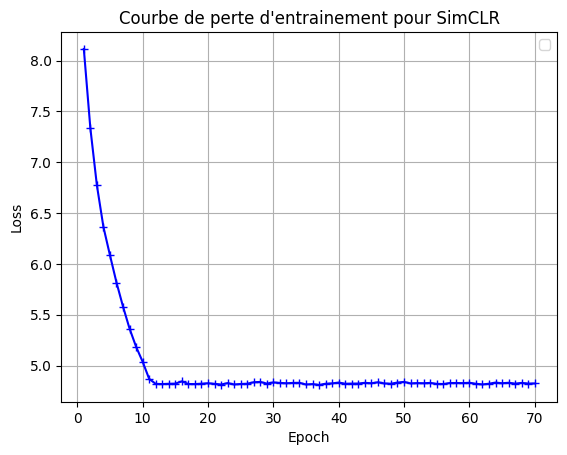

In [10]:
step = [i for i in range(1,epochs+1)]
plt.plot(step, trainer.loss_list, marker = '+', color='b')
plt.title("Courbe de perte d'entrainement pour SimCLR")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.plot()

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms


class LinearProbingDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

    def __len__(self):
        return len(self.data)


class linear_prob_Trainer:
    def __init__(self, model, optimizer, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        self.loss_list = []
        self.top_1_acc_list = []
        self.train_dataset = datasets.CIFAR10(
            "./data", train=True, download=True, transform=transforms.ToTensor()
        )

        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=1,
            drop_last=False,
        )

        self.test_dataset = datasets.CIFAR10(
            "./data", train=False, download=True, transform=transforms.ToTensor()
        )

        self.test_loader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=batch_size,
            num_workers=1,
            drop_last=False,
        )

    def accuracy(self, output, target, topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(100.0 / batch_size))
            return res

    def train(self):
        for epoch in range(100):
            top1_train_accuracy = 0
            for images, labels in tqdm(self.train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                top1 = self.accuracy(logits, labels, topk=(1,))
                top1_train_accuracy += top1[0]

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.loss_list.append(loss.item())
                self.top_1_acc_list.append(top1_train_accuracy.item() / len(self.train_loader))
            print(
                f"Epoch: {epoch}, Loss: {loss.item()}",
                "Top1 Train Accuracy: ",
                top1_train_accuracy.item() / len(self.train_loader),
            )
        return self.model

    def test(self):
        with torch.no_grad():
            model.eval()
            top1_test_accuracy = 0
            top5_test_accuracy = 0
            for images, labels in tqdm(self.test_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                top1 = self.accuracy(logits, labels, topk=(1,))
                top1_test_accuracy += top1[0]
                top5 = self.accuracy(logits, labels, topk=(5,))
                top5_test_accuracy += top5[0]
            print(
                "Top1 Test Accuracy: ",
                top1_test_accuracy.item() / len(self.test_loader),
            )
            print(
                "Top5 Test Accuracy: ",
                top5_test_accuracy.item() / len(self.test_loader),
            )
            return

In [12]:
class_dim = 10
best_model.linear_probe(class_dim=class_dim)
linear_probe_optimizer = torch.optim.Adam(
    best_model.parameters(), lr=lr, weight_decay=weight_decay
)
linear_prob_trainer = linear_prob_Trainer(
    model=best_model, optimizer=linear_probe_optimizer, batch_size=batch_size
)
model = linear_prob_trainer.train()
linear_prob_trainer.test()

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 0, Loss: 2.3734188079833984 Top1 Train Accuracy:  10.654104793772978


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 1, Loss: 2.2151639461517334 Top1 Train Accuracy:  16.942364860983457


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 2, Loss: 2.1021206378936768 Top1 Train Accuracy:  22.270683737362134


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 3, Loss: 2.0219945907592773 Top1 Train Accuracy:  26.06717098460478


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 4, Loss: 1.9611262083053589 Top1 Train Accuracy:  28.93023681640625


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 5, Loss: 1.9127721786499023 Top1 Train Accuracy:  31.25115966796875


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 6, Loss: 1.8740350008010864 Top1 Train Accuracy:  32.79039091222427


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 7, Loss: 1.8421663045883179 Top1 Train Accuracy:  34.05652214499081


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 8, Loss: 1.8154650926589966 Top1 Train Accuracy:  35.064155129825366


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 9, Loss: 1.792745590209961 Top1 Train Accuracy:  35.838217342601105


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 10, Loss: 1.7731072902679443 Top1 Train Accuracy:  36.504035500919116


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 11, Loss: 1.7559260129928589 Top1 Train Accuracy:  37.07704072840073


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 12, Loss: 1.7407270669937134 Top1 Train Accuracy:  37.53370935776655


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 13, Loss: 1.727154016494751 Top1 Train Accuracy:  37.923828125


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 14, Loss: 1.7149325609207153 Top1 Train Accuracy:  38.27496337890625


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 15, Loss: 1.703848123550415 Top1 Train Accuracy:  38.617715274586395


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 16, Loss: 1.6937304735183716 Top1 Train Accuracy:  38.93723790785845


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 17, Loss: 1.6844427585601807 Top1 Train Accuracy:  39.21416877297794


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 18, Loss: 1.6758736371994019 Top1 Train Accuracy:  39.492758358226105


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 19, Loss: 1.6679308414459229 Top1 Train Accuracy:  39.744072409237134


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 20, Loss: 1.6605379581451416 Top1 Train Accuracy:  39.896534639246326


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 21, Loss: 1.6536308526992798 Top1 Train Accuracy:  40.104054170496326


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 22, Loss: 1.647154450416565 Top1 Train Accuracy:  40.222056669347424


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 23, Loss: 1.6410620212554932 Top1 Train Accuracy:  40.364695829503674


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 24, Loss: 1.6353144645690918 Top1 Train Accuracy:  40.5137939453125


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 25, Loss: 1.6298766136169434 Top1 Train Accuracy:  40.632514504825366


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 26, Loss: 1.624718189239502 Top1 Train Accuracy:  40.801492130055145


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 27, Loss: 1.6198128461837769 Top1 Train Accuracy:  40.94174373851103


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 28, Loss: 1.615138053894043 Top1 Train Accuracy:  41.09922880284927


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 29, Loss: 1.6106733083724976 Top1 Train Accuracy:  41.244029325597424


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 30, Loss: 1.6064003705978394 Top1 Train Accuracy:  41.34573184742647


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 31, Loss: 1.602303385734558 Top1 Train Accuracy:  41.42926025390625


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 32, Loss: 1.5983691215515137 Top1 Train Accuracy:  41.565684599034924


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 33, Loss: 1.5945838689804077 Top1 Train Accuracy:  41.71023380055147


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 34, Loss: 1.5909373760223389 Top1 Train Accuracy:  41.80453670726103


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 35, Loss: 1.587419033050537 Top1 Train Accuracy:  41.91487031824448


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 36, Loss: 1.5840197801589966 Top1 Train Accuracy:  42.05056942210478


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 37, Loss: 1.5807313919067383 Top1 Train Accuracy:  42.13720703125


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 38, Loss: 1.5775471925735474 Top1 Train Accuracy:  42.22337431066177


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 39, Loss: 1.5744596719741821 Top1 Train Accuracy:  42.27962718290441


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 40, Loss: 1.5714633464813232 Top1 Train Accuracy:  42.42059685202206


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 41, Loss: 1.5685523748397827 Top1 Train Accuracy:  42.52017391429228


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 42, Loss: 1.565721869468689 Top1 Train Accuracy:  42.64199649586397


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 43, Loss: 1.56296706199646 Top1 Train Accuracy:  42.70399385340073


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 44, Loss: 1.5602848529815674 Top1 Train Accuracy:  42.797567928538605


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 45, Loss: 1.5576696395874023 Top1 Train Accuracy:  42.86267448874081


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 46, Loss: 1.5551193952560425 Top1 Train Accuracy:  42.9519473805147


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 47, Loss: 1.552629828453064 Top1 Train Accuracy:  42.9936092601103


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 48, Loss: 1.5501984357833862 Top1 Train Accuracy:  43.077859317555145


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 49, Loss: 1.5478219985961914 Top1 Train Accuracy:  43.16904943129595


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 50, Loss: 1.5454989671707153 Top1 Train Accuracy:  43.21811092601103


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 51, Loss: 1.5432262420654297 Top1 Train Accuracy:  43.28249583524816


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 52, Loss: 1.5410012006759644 Top1 Train Accuracy:  43.35644172219669


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 53, Loss: 1.5388224124908447 Top1 Train Accuracy:  43.42849192899816


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 54, Loss: 1.5366876125335693 Top1 Train Accuracy:  43.494790469898895


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 55, Loss: 1.5345953702926636 Top1 Train Accuracy:  43.56346220128677


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 56, Loss: 1.5325433015823364 Top1 Train Accuracy:  43.61708338120405


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 57, Loss: 1.5305306911468506 Top1 Train Accuracy:  43.647715849034924


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 58, Loss: 1.5285553932189941 Top1 Train Accuracy:  43.677163516773895


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 59, Loss: 1.526616096496582 Top1 Train Accuracy:  43.725503360523895


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 60, Loss: 1.5247118473052979 Top1 Train Accuracy:  43.77984260110294


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 61, Loss: 1.522841215133667 Top1 Train Accuracy:  43.786308737362134


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 62, Loss: 1.5210025310516357 Top1 Train Accuracy:  43.849498075597424


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 63, Loss: 1.5191954374313354 Top1 Train Accuracy:  43.915322696461395


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 64, Loss: 1.5174181461334229 Top1 Train Accuracy:  43.94022144990809


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 65, Loss: 1.515670657157898 Top1 Train Accuracy:  43.972767549402576


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 66, Loss: 1.5139508247375488 Top1 Train Accuracy:  44.03332160500919


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 67, Loss: 1.512258768081665 Top1 Train Accuracy:  44.114939970128674


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 68, Loss: 1.5105928182601929 Top1 Train Accuracy:  44.123786477481616


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 69, Loss: 1.5089527368545532 Top1 Train Accuracy:  44.175953584558826


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 70, Loss: 1.5073375701904297 Top1 Train Accuracy:  44.221442727481616


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 71, Loss: 1.5057464838027954 Top1 Train Accuracy:  44.29276051240809


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 72, Loss: 1.5041788816452026 Top1 Train Accuracy:  44.31765567555147


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 73, Loss: 1.5026341676712036 Top1 Train Accuracy:  44.41195858226103


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 74, Loss: 1.5011112689971924 Top1 Train Accuracy:  44.49020565257353


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 75, Loss: 1.499610185623169 Top1 Train Accuracy:  44.55148135914522


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 76, Loss: 1.498129963874817 Top1 Train Accuracy:  44.5959903492647


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 77, Loss: 1.4966700077056885 Top1 Train Accuracy:  44.638589298023895


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 78, Loss: 1.4952300786972046 Top1 Train Accuracy:  44.679525936351105


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 79, Loss: 1.4938092231750488 Top1 Train Accuracy:  44.732414694393384


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 80, Loss: 1.4924074411392212 Top1 Train Accuracy:  44.78866756663603


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 81, Loss: 1.4910237789154053 Top1 Train Accuracy:  44.82049560546875


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 82, Loss: 1.489657998085022 Top1 Train Accuracy:  44.86764346852022


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 83, Loss: 1.488309621810913 Top1 Train Accuracy:  44.897561465992645


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 84, Loss: 1.4869781732559204 Top1 Train Accuracy:  44.9324951171875


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 85, Loss: 1.485663652420044 Top1 Train Accuracy:  44.94015682444853


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 86, Loss: 1.4843648672103882 Top1 Train Accuracy:  44.958108340992645


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 87, Loss: 1.4830824136734009 Top1 Train Accuracy:  45.002875832950366


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 88, Loss: 1.481815218925476 Top1 Train Accuracy:  45.072272805606616


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 89, Loss: 1.4805630445480347 Top1 Train Accuracy:  45.11440860523897


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 90, Loss: 1.479325771331787 Top1 Train Accuracy:  45.15125947840073


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 91, Loss: 1.4781029224395752 Top1 Train Accuracy:  45.181895536534924


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 92, Loss: 1.4768940210342407 Top1 Train Accuracy:  45.2084530101103


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 93, Loss: 1.4756991863250732 Top1 Train Accuracy:  45.221852022058826


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 94, Loss: 1.474517822265625 Top1 Train Accuracy:  45.2486572265625


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 95, Loss: 1.473349690437317 Top1 Train Accuracy:  45.25631893382353


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 96, Loss: 1.4721943140029907 Top1 Train Accuracy:  45.2754696116728


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 97, Loss: 1.471051812171936 Top1 Train Accuracy:  45.31112491383272


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 98, Loss: 1.4699219465255737 Top1 Train Accuracy:  45.320700252757355


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 99, Loss: 1.468803882598877 Top1 Train Accuracy:  45.330272001378674


100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

Top1 Test Accuracy:  44.09993362426758
Top5 Test Accuracy:  90.00468444824219


[]

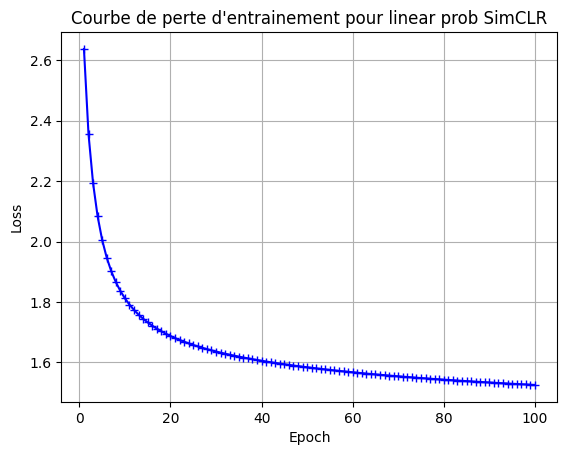

In [ ]:
loss_l = [linear_prob_trainer.loss_list[i*17] for i in range(100)]
step = [i for i in range(1,101)]
plt.plot(step, loss_l, marker = '+', color='b')
plt.title("Courbe de perte d'entrainement pour linear prob SimCLR")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.plot()

[]

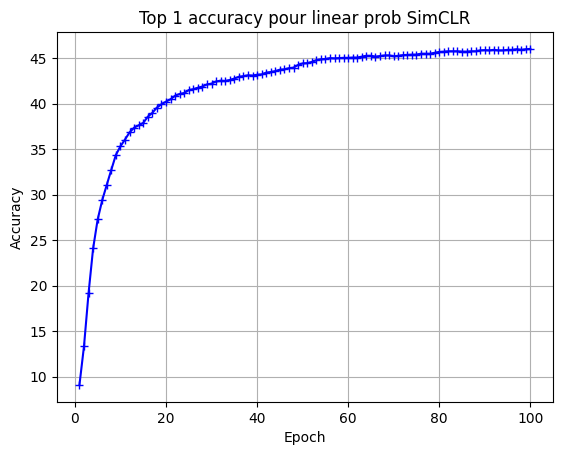

In [23]:
top1_l = [linear_prob_trainer.top_1_acc_list[i*17]*len(linear_prob_trainer.train_loader) for i in range(100)]
plt.plot(step, top1_l, marker = '+', color='b')
plt.title("Top 1 accuracy pour linear prob SimCLR")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.plot()